In [5]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

lb = LabelBinarizer()
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

train_data = pd.read_csv('ScooterData_July15_Sept27_2019.csv')
train_data = train_data.sample(frac=1)
train_data['start_date'] = pd.to_datetime(train_data.start_date)
train_data['start_day_of_week'] = train_data.start_day_of_week.str.extract(r'(\d+[.\d]*)')
train_data['startx'] = (train_data['startx'])
train_data['endx'] = (train_data['endx'])
train_data['starty'] = (train_data['starty'])
train_data['endy'] = (train_data['endy'])



In [6]:
grid_data = gpd.read_file("ScooterGridId.shp")
# grid_data = grid_data[grid_data['grid_id'].notnull()]
# grid_data = grid_data[grid_data['start_grid'].notnull()]
# grid_data = grid_data[grid_data['end_grid_c'].notnull()]
grid_id = grid_data[grid_data['grid_id'].notnull()]['grid_id']
le.fit_transform(grid_id)

train_data = train_data[train_data.ending_grid_id.isin(grid_id)]
train_data['ending_grid_id'] = le.transform(train_data['ending_grid_id'])
train_data['starting_grid_id'] = le.transform(train_data['starting_grid_id'])


In [7]:

Y_data = train_data[['endx','endy']].to_numpy()
X_data = train_data[['start_day_of_week','start_hour','trip_duration_min','trip_length_km','startx','starty']].to_numpy()
from sklearn.preprocessing import MinMaxScaler


sc = MinMaxScaler(feature_range=(-1,1))
X_data = sc.fit_transform(X_data)
Y_data = sc.fit_transform(Y_data)

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.30, random_state=10)

In [8]:
# kf = KFold(5, shuffle=True, random_state=42)

mlp = Sequential()
mlp.add( Dense(50,activation='relu',input_shape=x_train[0].shape) )

mlp.add( Dense(y_train.shape[1]))
mlp.compile(loss="mean_absolute_error", optimizer="adam", metrics=["acc"])
mlp.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                350       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


In [9]:
callback = EarlyStopping(monitor='loss', patience=3)
mlp.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[callback])


Train on 320830 samples, validate on 137499 samples
Epoch 1/100
320830/320830 [==============================] - 10s 30us/sample - loss: 0.0387 - acc: 0.7489 - val_loss: 0.0370 - val_acc: 0.7563
Epoch 2/100
320830/320830 [==============================] - 10s 31us/sample - loss: 0.0372 - acc: 0.7521 - val_loss: 0.0369 - val_acc: 0.7569
Epoch 3/100
320830/320830 [==============================] - 10s 30us/sample - loss: 0.0367 - acc: 0.7522 - val_loss: 0.0364 - val_acc: 0.7535
Epoch 4/100
320830/320830 [==============================] - 10s 31us/sample - loss: 0.0363 - acc: 0.7533 - val_loss: 0.0359 - val_acc: 0.7548
Epoch 5/100
320830/320830 [==============================] - 9s 27us/sample - loss: 0.0360 - acc: 0.7529 - val_loss: 0.0357 - val_acc: 0.7547
Epoch 6/100
320830/320830 [==============================] - 9s 28us/sample - loss: 0.0358 - acc: 0.7532 - val_loss: 0.0358 - val_acc: 0.7529
Epoch 7/100
320830/320830 [==============================] - 9s 30us/sample - loss: 0.0357 -

320830/320830 [==============================] - 9s 28us/sample - loss: 0.0352 - acc: 0.7555 - val_loss: 0.0354 - val_acc: 0.7549
Epoch 57/100
320830/320830 [==============================] - 9s 27us/sample - loss: 0.0352 - acc: 0.7554 - val_loss: 0.0352 - val_acc: 0.7548


In [10]:
mlp.evaluate(x_test,y_test)

137499/137499 [==============================] - 1s 10us/sample - loss: 0.0352 - acc: 0.7548


[0.03516278336448525, 0.75484186]

In [11]:
result_Y = mlp.predict(x_test)
Y_test_in = y_test
error = abs(result_Y - Y_test_in)
endx = sum(error[:,0])/len(error)
endy = sum(error[:,1])/len(error)
error_average_distance = (endx+endy)/2

y_test[:,0] = y_test[:,0]

error_average_distance*	111.32

3.9143210444389656

In [12]:
result_Y = sc.inverse_transform(result_Y)
result_Y

array([[-114.06859 ,   51.04755 ],
       [-114.14611 ,   51.05789 ],
       [-114.087105,   51.043915],
       ...,
       [-114.059814,   51.03958 ],
       [-114.07327 ,   51.050003],
       [-114.06937 ,   51.045444]], dtype=float32)

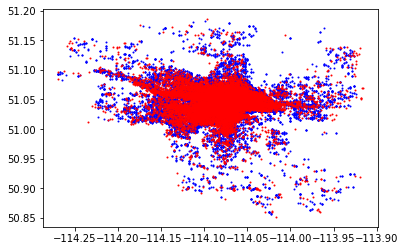

In [13]:
plt.scatter((train_data['endx']),(train_data['endy']), color='b', s= 1)
plt.scatter((result_Y[:,0]), (result_Y[:,1]), color='r', s= 1)